In [1]:
import os
import glob as gb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
import datetime
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

In [6]:
DATASET_PATH = "V3.dataset-skin-deasease-capstone"

os.listdir(DATASET_PATH)

['1train',
 '2validation',
 '3test',
 'clean-dataset-train',
 'clean-dataset-validation',
 'sampah']

In [7]:
TRAIN_DIR = os.path.join(DATASET_PATH, 'clean-dataset-train')
VAL_DIR = os.path.join(DATASET_PATH, 'clean-dataset-validation')
TEST_DIR = os.path.join(DATASET_PATH, '3test')

In [8]:
def img_count_in_folder(FOLDER_PATH):  
    print('-'*70)
    for folder in os.listdir(FOLDER_PATH):
        files=gb.glob(pathname=str(FOLDER_PATH + '/' + folder + '/*.jpg'))
        print(f'{len(files):4} gambar yang ditemukan di dalam folder {folder}')
    print('-'*70)

In [9]:
print("TRAIN DIR")
img_count_in_folder(TRAIN_DIR)
print("VAL_DIR")
img_count_in_folder(VAL_DIR)
print("TEST_DIR")
img_count_in_folder(TEST_DIR)

TRAIN DIR
----------------------------------------------------------------------
 253 gambar yang ditemukan di dalam folder Acne Vulgaris
 274 gambar yang ditemukan di dalam folder Actinic Keratosis
 411 gambar yang ditemukan di dalam folder Nail Fungus
 593 gambar yang ditemukan di dalam folder Psoriasis
 211 gambar yang ditemukan di dalam folder Seborrheic Keratoses
----------------------------------------------------------------------
VAL_DIR
----------------------------------------------------------------------
 114 gambar yang ditemukan di dalam folder Acne Vulgaris
 100 gambar yang ditemukan di dalam folder Actinic Keratosis
 216 gambar yang ditemukan di dalam folder Nail Fungus
 217 gambar yang ditemukan di dalam folder Psoriasis
 138 gambar yang ditemukan di dalam folder Seborrheic Keratoses
----------------------------------------------------------------------
TEST_DIR
----------------------------------------------------------------------
 100 gambar yang ditemukan di dalam fo

In [10]:
def show_images(img_files):
    plt.figure()
    fig = plt.figure(figsize=(10, 10))
    fig.patch.set_facecolor('xkcd:gray')
    
    for i in range(len(img_files)):
        plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        img=mpimg.imread(img_files[i])
        plt.imshow(img)
        plt.tight_layout()
        plt.axis('off')
        plt.title(img_files[i].split('\\')[2]) 
    
    plt.show()

In [11]:
def list_files(dir):
    arr=[]
    for root,dirs, files in os.walk(dir):
        for name in files:
            if name.endswith('.jpg'):
                arr.append(os.path.join(root, name))
                break
    return arr

<Figure size 640x480 with 0 Axes>

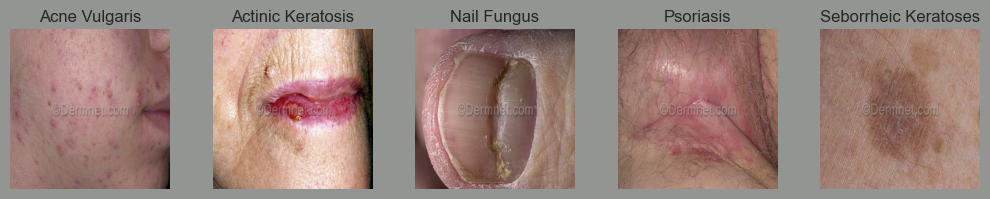

<Figure size 640x480 with 0 Axes>

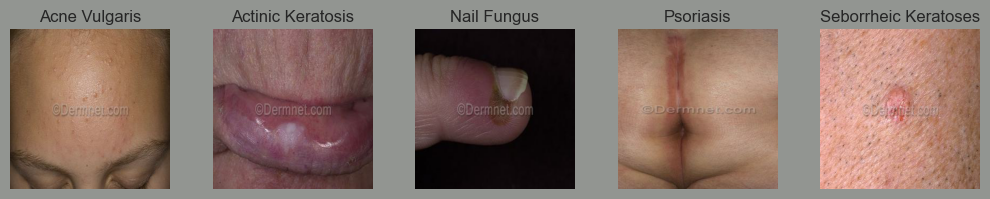

<Figure size 640x480 with 0 Axes>

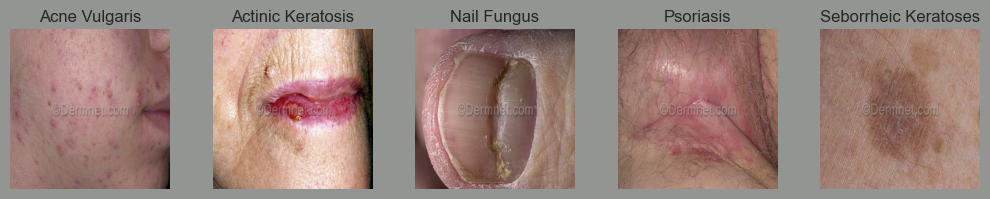

In [12]:
img_list1= list_files(TRAIN_DIR)
show_images(img_list1)

img_list2= list_files(VAL_DIR)
show_images(img_list2)

img_list3= list_files(TEST_DIR)
show_images(img_list1)

In [14]:
def img_segmentation(img, k=4):
    
  # img = cv2.imread(img_path)
  # img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
  # img = img_path
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers=np.uint8(centers)
    labels = labels.flatten()
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape(img.shape)
    masked_img =  np.copy(img)
    masked_img = masked_img.reshape((-1, 3))
    cluster = 2
    masked_img[labels==cluster] = [0, 0, 0]
    masked_img = masked_img.reshape(img.shape)

    return masked_img

In [15]:
# Datagen for validation set dan training set
datagen = ImageDataGenerator(#preprocessing_function=img_segmentation,
                             rescale = 1./255,
                             rotation_range = 40,
                             zoom_range = 0.2,
                             width_shift_range=0.2, 
                             shear_range= 0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip= True,
                             fill_mode='nearest',
                             )

# ImageDataGenerator for test set
val_datagen = ImageDataGenerator(#preprocessing_function=img_segmentation,
                                 rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
IMG_SIZE = (150, 150)

# Create train dataset
train_set = datagen.flow_from_directory(TRAIN_DIR, 
                                        class_mode='categorical', 
                                        batch_size= 64,
                                        target_size=IMG_SIZE,
                                        seed=42)

val_set = test_datagen.flow_from_directory(VAL_DIR, 
                                           class_mode='categorical', 
                                           batch_size= 64,
                                           target_size=IMG_SIZE,)

test_set = test_datagen.flow_from_directory(TEST_DIR, 
                                           class_mode='categorical', 
                                           batch_size= 64,
                                           target_size=IMG_SIZE,)

Found 1742 images belonging to 5 classes.
Found 785 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [17]:
print(train_set.class_indices)
print("-"*25)
print(val_set.class_indices)
print("-"*25)
print(test_set.class_indices)

{'Acne Vulgaris': 0, 'Actinic Keratosis': 1, 'Nail Fungus': 2, 'Psoriasis': 3, 'Seborrheic Keratoses': 4}
-------------------------
{'Acne Vulgaris': 0, 'Actinic Keratosis': 1, 'Nail Fungus': 2, 'Psoriasis': 3, 'Seborrheic Keratoses': 4}
-------------------------
{'Acne Vulgaris': 0, 'Actinic Keratosis': 1, 'Nail Fungus': 2, 'Psoriasis': 3, 'Seborrheic Keratoses': 4}


In [18]:
# Create variabel X_train and y_train
X_train, y_train = train_set.next()

# Create variabel X_test and y_test
X_val, y_val = val_set.next()

# Create variabel X_test and y_test
X_test, y_test = test_set.next()

In [129]:
print(X_train.shape)
print("-"*25)
print(X_val.shape)
print("-"*25)
print(X_test.shape)
print("-"*25)

(64, 150, 150, 3)
-------------------------
(64, 150, 150, 3)
-------------------------
(64, 150, 150, 3)
-------------------------


In [130]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=1e-8)
checkpoint_cb = ModelCheckpoint("ModelingV3.h5", saved_best_only=True)
early_stop_cb = EarlyStopping(patience=10,monitor='val_loss', restore_best_weights= True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Clear any logs from previous runs
#!rm -rf ./logs/ 

callbacks =[reduce_lr, checkpoint_cb, early_stop_cb, tensorboard_callback]

In [4]:
def evaluate_model(model, X, y):
    print('Loss of the model is - ', model.evaluate(X, y)[0])
    print('Accuracy of the model is - ', model.evaluate(X, y)[1]*100, '%')
    predict = model.predict(X)
  # print(predict)
    predict = np.argmax(predict, axis=1)
    predict = predict.reshape(1, -1)[0]
    y_label = np.argmax(y, axis=1)
    print(classification_report(y_label, predict, target_names =['Acne Vulgaris', 'Actinic Keratosis', 'Nail Fungus', 
                                                                'Psoriasis', 'Seborrheic Keratoses']))

    conf_matrix = confusion_matrix(y_label, predict)
  # print(conf_matrix)
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in ('Acne Vulgaris', 'Actinic Keratosis', 'Nail Fungus', 
                                                                'Psoriasis', 'Seborrheic Keratoses')],
                         columns = [i for i in ('Acne Vulgaris', 'Actinic Keratosis', 'Nail Fungus', 
                                                                'Psoriasis', 'Seborrheic Keratoses')])
    plt.figure(figsize = (3, 3))
    sns.heatmap(df_cm, annot=True)

plt.style.use('seaborn-whitegrid')

def plot_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plt.subplot(1, 2, 1)
    acc_plot, = plt.plot(epochs, acc, 'orange')
    val_acc_plot, = plt.plot(epochs, val_acc, 'blue')
    plt.title('Training and Validation Accuracy')
    plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.subplot(1, 2, 2)
    loss_plot, = plt.plot(epochs, loss, 'orange')
    val_loss_plot, = plt.plot(epochs, val_loss, 'blue')
    plt.title('Training and Validation Loss')
    plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_hist(history):
    plt.figure(figsize=(15,5))
    plot_acc(history)
    plot_loss(history)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10336\966126161.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [132]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [133]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [134]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  
x = layers.Dense(5, activation='softmax')(x)        

model = Model(pre_trained_model.input, x)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 74, 74, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                            

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_292 (Batch  (None, 16, 16, 96)  288         ['conv2d_292[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_293 (Batch  (None, 16, 16, 32)  96          ['conv2d_293[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_287 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_287[0][0]']
                                                                                                  
 activatio

 activation_304 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_304[0][0]']
                                                                                                  
 conv2d_302 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_305 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_304[0][0]']         
                                                                                                  
 batch_normalization_302 (Batch  (None, 16, 16, 48)  144         ['conv2d_302[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_305 (Batch  (None, 16, 16, 96)  288         ['conv2d_305[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_308[0][0]',         
                                                                  'activation_311[0][0]',         
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_316 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_316 (Batch  (None, 7, 7, 128)   384         ['conv2d_316[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_316 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_316[0][0]']
          

                                                                                                  
 batch_normalization_326 (Batch  (None, 7, 7, 160)   480         ['conv2d_326[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_326 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_326[0][0]']
                                                                                                  
 conv2d_327 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_326[0][0]']         
                                                                                                  
 batch_normalization_327 (Batch  (None, 7, 7, 160)   480         ['conv2d_327[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_337 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_336[0][0]']         
                                                                                                  
 batch_normalization_337 (Batch  (None, 7, 7, 160)   480         ['conv2d_337[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_337 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_337[0][0]']
                                                                                                  
 conv2d_333 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_33

                                                                                                  
 activation_347 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_347[0][0]']
                                                                                                  
 conv2d_343 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_348 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_347[0][0]']         
                                                                                                  
 batch_normalization_343 (Batch  (None, 7, 7, 192)   576         ['conv2d_343[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

In [135]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
# Set the training parameters
model.compile(optimizer = Adam(), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [136]:
# Trains for 20 epochs
hist = model.fit(train_set, epochs=10, validation_data = val_set, verbose = 1, callbacks=callbacks)

Epoch 1/10
28/28 [==============================] - 126s 4s/step - loss: 3.8655 - accuracy: 0.4908 - val_loss: 1.3927 - val_accuracy: 0.6229 - lr: 0.0010
Epoch 2/10
28/28 [==============================] - 103s 4s/step - loss: 0.8155 - accuracy: 0.7153 - val_loss: 1.0620 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 3/10
28/28 [==============================] - 90s 3s/step - loss: 0.6589 - accuracy: 0.7497 - val_loss: 1.0096 - val_accuracy: 0.6981 - lr: 0.0010
Epoch 4/10
28/28 [==============================] - 109s 4s/step - loss: 0.6583 - accuracy: 0.7595 - val_loss: 0.9054 - val_accuracy: 0.6968 - lr: 0.0010
Epoch 5/10
28/28 [==============================] - 98s 4s/step - loss: 0.5947 - accuracy: 0.7727 - val_loss: 0.9269 - val_accuracy: 0.7134 - lr: 0.0010
Epoch 6/10
28/28 [==============================] - 95s 3s/step - loss: 0.5391 - accuracy: 0.8123 - val_loss: 0.8214 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 7/10
28/28 [==============================] - 95s 3s/step - loss: 0.5494 

In [145]:
optimizer=Adam()

# unfreeze last 10 layers and include them in training process
for layer in pre_trained_model.layers[-15:]:
    layer.trainable=True
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 74, 74, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                            

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_292 (Batch  (None, 16, 16, 96)  288         ['conv2d_292[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_293 (Batch  (None, 16, 16, 32)  96          ['conv2d_293[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_287 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_287[0][0]']
                                                                                                  
 activatio

 activation_304 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_304[0][0]']
                                                                                                  
 conv2d_302 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_305 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_304[0][0]']         
                                                                                                  
 batch_normalization_302 (Batch  (None, 16, 16, 48)  144         ['conv2d_302[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_305 (Batch  (None, 16, 16, 96)  288         ['conv2d_305[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_308[0][0]',         
                                                                  'activation_311[0][0]',         
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_316 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_316 (Batch  (None, 7, 7, 128)   384         ['conv2d_316[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_316 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_316[0][0]']
          

                                                                                                  
 batch_normalization_326 (Batch  (None, 7, 7, 160)   480         ['conv2d_326[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_326 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_326[0][0]']
                                                                                                  
 conv2d_327 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_326[0][0]']         
                                                                                                  
 batch_normalization_327 (Batch  (None, 7, 7, 160)   480         ['conv2d_327[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_337 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_336[0][0]']         
                                                                                                  
 batch_normalization_337 (Batch  (None, 7, 7, 160)   480         ['conv2d_337[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_337 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_337[0][0]']
                                                                                                  
 conv2d_333 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_33

                                                                                                  
 activation_347 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_347[0][0]']
                                                                                                  
 conv2d_343 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_348 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_347[0][0]']         
                                                                                                  
 batch_normalization_343 (Batch  (None, 7, 7, 192)   576         ['conv2d_343[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

In [152]:
# Retrain the model with 100 epochs
hist = model.fit(train_set, epochs=100, validation_data = val_set, verbose = 1, callbacks=callbacks,)

Epoch 1/100
28/28 [==============================] - 99s 4s/step - loss: 0.4274 - accuracy: 0.8439 - val_loss: 0.9561 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 94s 3s/step - loss: 0.4283 - accuracy: 0.8398 - val_loss: 0.9003 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 98s 4s/step - loss: 0.4254 - accuracy: 0.8370 - val_loss: 0.9032 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 95s 3s/step - loss: 0.4374 - accuracy: 0.8307 - val_loss: 0.8948 - val_accuracy: 0.7465 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - 91s 3s/step - loss: 0.4137 - accuracy: 0.8542 - val_loss: 0.9951 - val_accuracy: 0.7427 - lr: 0.0010
Epoch 6/100
28/28 [==============================] - 96s 3s/step - loss: 0.4456 - accuracy: 0.8444 - val_loss: 0.8623 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 7/100
28/28 [==============================] - 96s 3s/step - loss: 0.4

2/2 [==============================] - 2s 665ms/step - loss: 0.6664 - accuracy: 0.7812
Loss of the model is -  0.6664436459541321
2/2 [==============================] - 1s 627ms/step - loss: 0.6664 - accuracy: 0.7812
Accuracy of the model is -  78.125 %
2/2 [==============================] - 1s 608ms/step
                      precision    recall  f1-score   support

       Acne Vulgaris       0.85      0.85      0.85        13
   Actinic Keratosis       0.45      0.71      0.56         7
         Nail Fungus       0.94      1.00      0.97        17
           Psoriasis       0.67      0.67      0.67        12
Seborrheic Keratoses       0.90      0.60      0.72        15

            accuracy                           0.78        64
           macro avg       0.76      0.77      0.75        64
        weighted avg       0.81      0.78      0.78        64



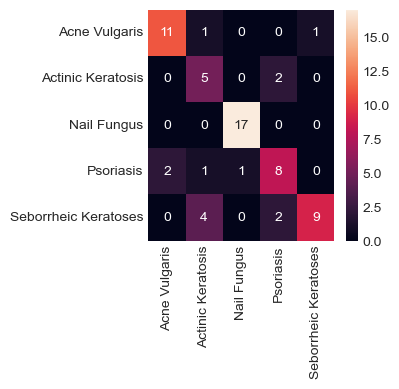

In [153]:
evaluate_model(model, X_test, y_test)

In [2]:
from keras.models import load_model

MODEL_PATH = 'ModelingV3.h5'

# Now save model in drive
#model.save(MODEL_PATH)

# Load Model
model1 = load_model(MODEL_PATH)

2/2 [==============================] - 3s 574ms/step - loss: 0.9024 - accuracy: 0.7969
Loss of the model is -  0.9024180173873901
2/2 [==============================] - 1s 586ms/step - loss: 0.9024 - accuracy: 0.7969
Accuracy of the model is -  79.6875 %
2/2 [==============================] - 7s 552ms/step
                      precision    recall  f1-score   support

       Acne Vulgaris       0.85      0.85      0.85        13
   Actinic Keratosis       0.80      0.57      0.67         7
         Nail Fungus       0.94      1.00      0.97        17
           Psoriasis       0.50      0.75      0.60        12
Seborrheic Keratoses       1.00      0.67      0.80        15

            accuracy                           0.80        64
           macro avg       0.82      0.77      0.78        64
        weighted avg       0.84      0.80      0.80        64



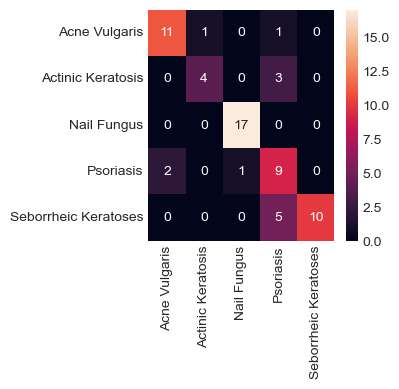

In [19]:
evaluate_model(model1, X_test, y_test)

2/2 [==============================] - 4s 3s/step - loss: 0.9024 - accuracy: 0.7969
Loss of the model is -  0.9024180173873901
2/2 [==============================] - 4s 1s/step - loss: 0.9024 - accuracy: 0.7969
Accuracy of the model is -  79.6875 %
2/2 [==============================] - 7s 6s/step
                      precision    recall  f1-score   support

       Acne Vulgaris       0.85      0.85      0.85        13
   Actinic Keratosis       0.80      0.57      0.67         7
         Nail Fungus       0.94      1.00      0.97        17
           Psoriasis       0.50      0.75      0.60        12
Seborrheic Keratoses       1.00      0.67      0.80        15

            accuracy                           0.80        64
           macro avg       0.82      0.77      0.78        64
        weighted avg       0.84      0.80      0.80        64



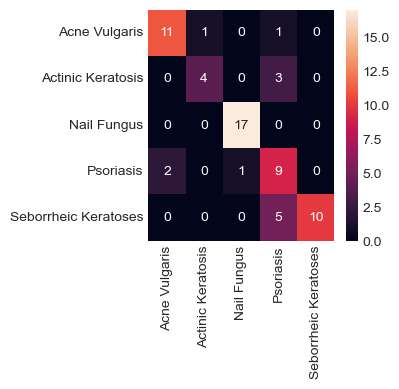

In [21]:
evaluate_model(model1, X_test, y_test)

In [156]:
# # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

images = os.listdir("./tmp/images")

print(images)

for i in images:
    print()
# predicting images
    path = './tmp/images/' + i
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model1.predict(images, batch_size=10)
    print(path)
    #print(classes)
    
    print("Acne Vulgaris")  
    print(classes[0][0])
    print("Actinic Keratosis")
    print(classes[0][1])
    print("Nail Fungus")
    print(classes[0][2])
    print("Psoriasis")
    print(classes[0][3])
    print("Seborrheic Keratoses")
    print(classes[0][4])

['acne-cystic-6.jpg', 'beaus-lines-14.jpg', 'psoriasis.jpg', 'seborrheic-keratoses-ruff-109.jpg']

1/1 [==============================] - 1s 1s/step
./tmp/images/acne-cystic-6.jpg
Acne Vulgaris
0.0
Actinic Keratosis
0.0
Nail Fungus
1.0
Psoriasis
0.0
Seborrheic Keratoses
0.0

1/1 [==============================] - 0s 78ms/step
./tmp/images/beaus-lines-14.jpg
Acne Vulgaris
0.0
Actinic Keratosis
0.0
Nail Fungus
1.0
Psoriasis
0.0
Seborrheic Keratoses
0.0

1/1 [==============================] - 0s 73ms/step
./tmp/images/psoriasis.jpg
Acne Vulgaris
0.0
Actinic Keratosis
0.0
Nail Fungus
0.9998944
Psoriasis
0.00010561774
Seborrheic Keratoses
0.0

1/1 [==============================] - 0s 82ms/step
./tmp/images/seborrheic-keratoses-ruff-109.jpg
Acne Vulgaris
0.0
Actinic Keratosis
0.0
Nail Fungus
1.0
Psoriasis
0.0
Seborrheic Keratoses
0.0


In [73]:
class_dict = {v : k for k, v in train_set.class_indices.items()}

In [84]:
# # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

images = os.listdir("./tmp/images")

print(images)

for i in images:
    print()
# predicting images
    path = './tmp/images/' + i
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    class_prediction = np.argmax(classes)
    prediction = class_dict[class_prediction]
    
    print(path)
    print('percentage:')
    print(classes)
    
    #print(path)
    #print(classes)
    
    #print("Acne Vulgaris")  
    #print(classes[0][0])
    #print("Actinic Keratosis")
    #print(classes[0][1])
    #print("Eczema")
    #print(classes[0][2])
    #print("Nail Fungus")
    #print(classes[0][3])
    #print("Psoriasis")
    #print(classes[0][4])
    #print("Seborrheic Keratoses")
    #print(classes[0][5])
    #print("Tinea")
    #print(classes[0][6])

['acne-closed-comedo-1.jpg', 'acne-cystic-6.jpg', 'distal-subungual-onychomycosis-86.jpg', 'psoriasis.jpg', 'seborrheic-keratoses-ruff-109.jpg']

1/1 [==============================] - 0s 116ms/step
./tmp/images/acne-closed-comedo-1.jpg
percentage:
[[0.000000e+00 0.000000e+00 5.896753e-24 1.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00]]

1/1 [==============================] - 0s 112ms/step
./tmp/images/acne-cystic-6.jpg
percentage:
[[0. 0. 1. 0. 0. 0. 0.]]

1/1 [==============================] - 0s 111ms/step
./tmp/images/distal-subungual-onychomycosis-86.jpg
percentage:
[[0. 0. 1. 0. 0. 0. 0.]]

1/1 [==============================] - 0s 100ms/step
./tmp/images/psoriasis.jpg
percentage:
[[0.         0.         0.3289874  0.         0.         0.
  0.67101264]]

1/1 [==============================] - 0s 113ms/step
./tmp/images/seborrheic-keratoses-ruff-109.jpg
percentage:
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 4.7775701e-27
  0.0000000e+00 2.3935097e-15]]
